In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pylab as plt
import seaborn as sns
import os
%matplotlib inline

# Facebook Check Ins
On Facebook, a user can check into a nearby location by selecting from a list of close locations from their GPS location, or by manually selecting a location. This posts to their social group that they are currently at the selected location and highlights the business or location they checked in to. The goal of this challenge, provided by Facebook, is to predict the check in location given only the location (with accuracy), and time. A large dataset has been provided with artifical data and is hosted by [Kaggle](https://www.kaggle.com/c/facebook-v-predicting-check-ins).

First, we will read in the data and do some preliminary exploration.

In [2]:
df = pd.read_csv('Data/train.csv', index_col='row_id')
final = pd.read_csv('Data/test.csv', index_col='row_id')

We can see that about 29 million data points have been provided. X and Y coordinates fall from 0 to 10 (were stated to have been given in kms) and accuracy falls from 1 to about 1000, although no further description was given. Time ranges from 1 to about 786 000 and no information about units were given. We will have to figure this out later.

In [3]:
df.describe()

,x,y,accuracy,time,place_id
count,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07
mean,4.999770e+00,5.001814e+00,8.284912e+01,4.170104e+05,5.493787e+09
std,2.857601e+00,2.887505e+00,1.147518e+02,2.311761e+05,2.611088e+09
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000016e+09
25%,2.534700e+00,2.496700e+00,2.700000e+01,2.030570e+05,3.222911e+09
50%,5.009100e+00,4.988300e+00,6.200000e+01,4.339220e+05,5.518573e+09
75%,7.461400e+00,7.510300e+00,7.500000e+01,6.204910e+05,7.764307e+09
max,1.000000e+01,1.000000e+01,1.033000e+03,7.862390e+05,9.999932e+09


## Location and Places
Let's start by looking for any large scale patterns in the density of the location data. If this were a real city we would expect some areas to see some larger scale trends that roughly follow the population density. Unfortunately, we do not see any trends in the location data. Since this was stated to be synthetic data, this isn't too surprising.

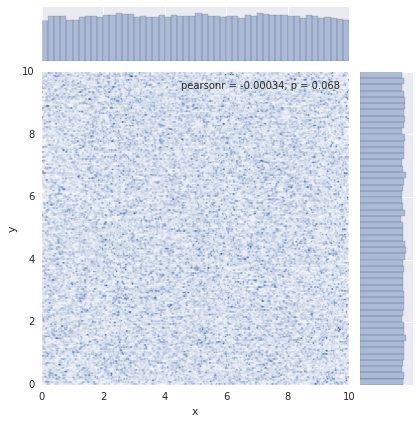

In [4]:
sns.jointplot(df['x'], df['y'], kind='hex')

We can then look at the distribution in check-ins across places. We see a strong peak with locations that have about 100 check-ins but also a long tail to the right.

Total number of places: 108390


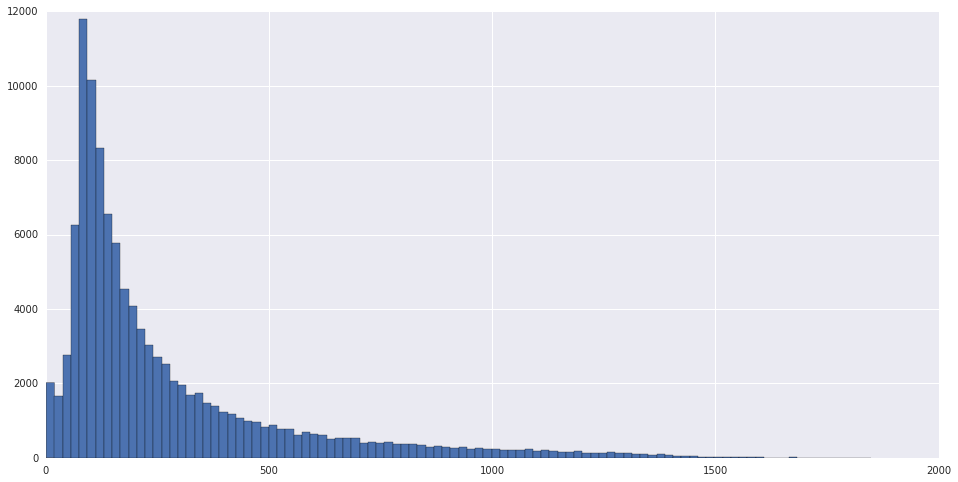

In [5]:
place_grouped = df.groupby('place_id')
print('Total number of places: %s' % len(place_grouped))
place_grouped.size().hist(bins=100, figsize=(16,8))

Let's look specifically at the check in locations for a couple of the top places.

In [6]:
highest_place_ids = place_grouped.size().sort_values(ascending=False)[:20].index
highest_places_df = df[df['place_id'].isin(highest_place_ids)]

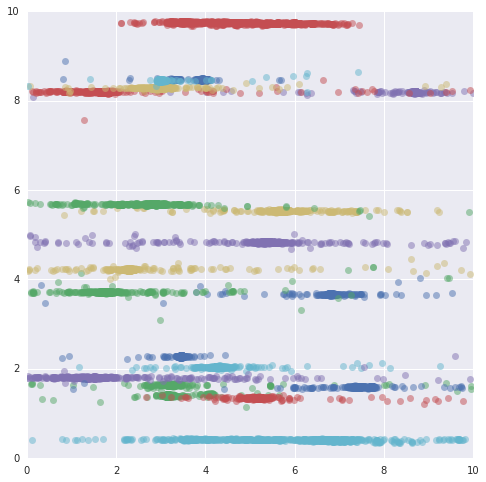

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
for place_id, group in highest_places_df.groupby('place_id'):
    ax.plot(group['x'], group['y'], 'o', alpha=.5)
ax.set_ylim([0,10])
ax.set_xlim([0, 10])
plt.show()

It seems that locations are very tightly grouped along the y-axis but very wide along the x-axis. Perhaps this coresponds to streets in this fictional city. Although we would expect to see vertical streets as well. We will need to keep this in mind when building a model as we will need to scale these axis accordingly.

To check if this observation holds true for all of our place ids, we can check the distribution of the standard deviation of each place id along each axis.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f775a6fcac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f775a67d080>]], dtype=object)

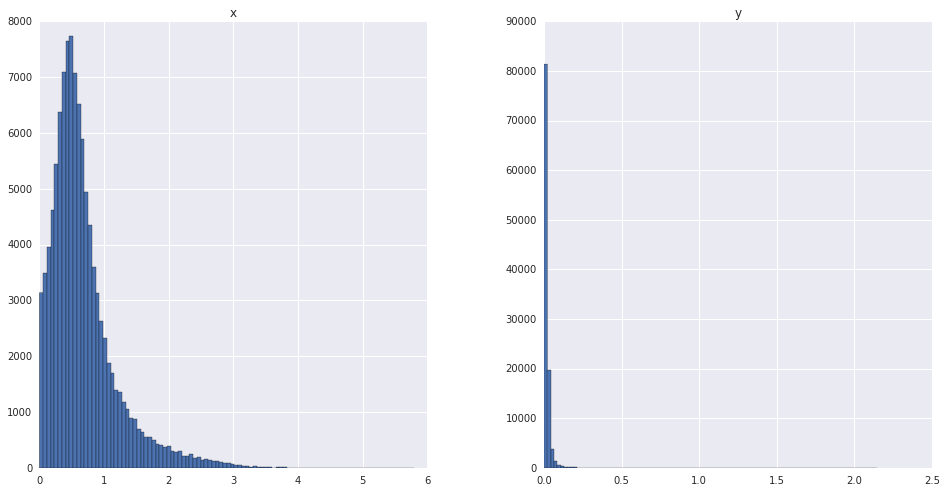

In [8]:
place_grouped[['x','y']].std().hist(bins=100, figsize=(16,8))

## Accuracy
Descriptions of the data fields were intentionally left vague so we are challenged to interpret them ourselves. Let's assume that accuracy is referencing the location information. GPS accuracy is typically given as a confidence interval. For instance, 5 would mean that the location is accurate to within a 5m radius with a high degree of confidence. If this is the case we would expect most points to have a small accuracy number with a long tail where users had a weaker connection to the GPS satelittes, the weather was poor, their device fell back to using wifi based location or other less then ideal conditions.

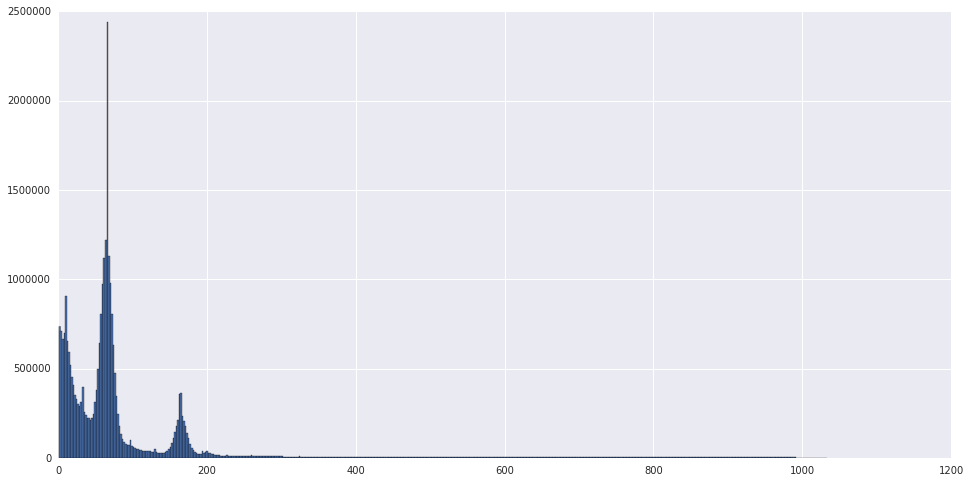

In [9]:
df['accuracy'].hist(bins=500, figsize=(16,8))

We can see a pretty interesting distribution in accuracy with three distinct peaks. This may correspond to discrete modes on the devices such as high/low precision GPS or wifi-only. Unfortunately we do not have user_ids for each check-in point otherwise we could check if the accuracy switches between mode for a given user. If the accuracy was constant for a given user we may have been able to infer the quality of the device they were using which may have been a usefull feature.

Let's check if there is any dependence between the variance in the x and y coordinates for each group and the median accuracy. We had assumed that accuracy referred to a radial distance but it might refer to a single axis.

The regression doesn't show any clear trends, but if we look at the three groups we saw in the histogram, the clusters with higher accuracy seem to be a tighter bunch closer to zero. This doesn't really hold true with the y-axis, but this may just be due to it's small scale. Taking our observation from the x-axis, this would mean that higher accuracy scores correspond to more accurate location readings.

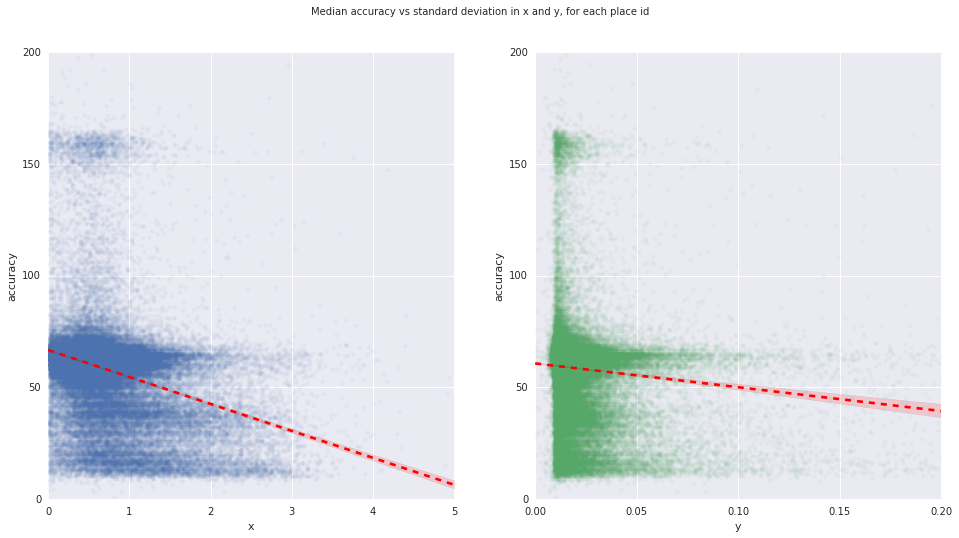

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for coord, ax in zip(['x', 'y'], axs):
    sns.regplot(x=place_grouped[coord].std(), y=place_grouped['accuracy'].median(), 
                truncate=True, ax=ax, line_kws={'color': 'red', 'linestyle': '--'},
                scatter_kws={'alpha': 0.05})
    ax.set_ylim([0, 200])
axs[0].set_xlim([0, 5]); axs[1].set_xlim([0, 0.2])
fig.suptitle('Median accuracy vs standard deviation in x and y, for each place id')

## Accuracy and distance from place centroids
We will use the centroid of all check ins locations at a given place id as an approximate location of the actual place. We would then expect to see a trend with precision decreasing with distance away from the centroid. We will do this calculation for a subset of places as it is computationally expensive.

In [11]:
centroid_df = highest_places_df.groupby('place_id').apply(lambda df: Series({'x_mean': df['x'].mean(), 
                                                                             'y_mean': df['y'].mean()}))

(0, 900)

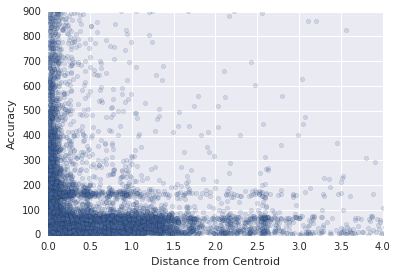

In [12]:
def dist_from_centroid(df):
    x = (df['x'] - centroid_df.ix[df['place_id']]['x_mean'])**2
    y = (df['y'] - centroid_df.ix[df['place_id']]['y_mean'])**2
    dist = np.sqrt(x+y)
    return dist
DataFrame({'Distance from Centroid': highest_places_df.apply(dist_from_centroid, axis=1),
           'Accuracy': highest_places_df['accuracy']}).plot(kind='scatter', 
                                                            x='Distance from Centroid', y='Accuracy', 
                                                            alpha=0.2)
plt.xlim([0, 4])
plt.ylim([0, 900])

This shows the same relationship as before, just with a slightly different spin.

## Unlocking time
Time is given as an integer from 0 to about 800 000. We are left to figure out the units on our own. Let's start by looking at the check in quantity as a function of time.

In [13]:
usage_count, usage_time = np.histogram(df['time'], bins=10000)
usage_time = usage_time[:-1]
fs = 1./(usage_time[1] - usage_time[0])

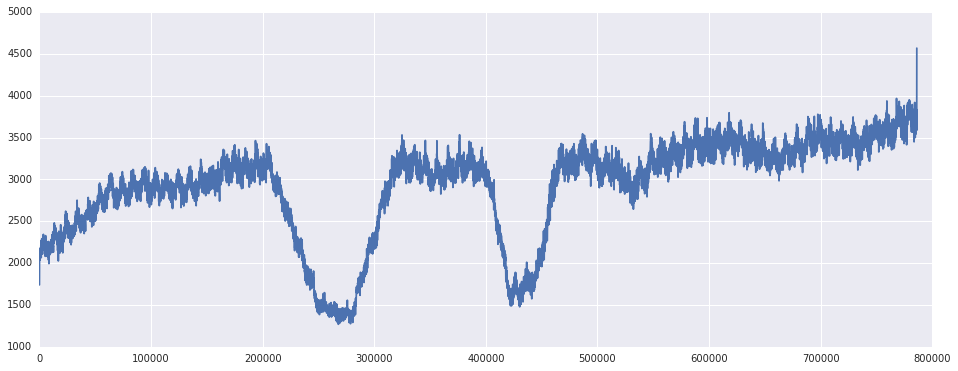

In [14]:
plt.subplots(1, 1, figsize=(16, 6))
plt.plot(usage_time, usage_count)

We can see a high frequency cycle on top of a lower frequency trend. We can do an FFT on this data to pull out the higher frequency components. These might correspond to the day or week cycles.

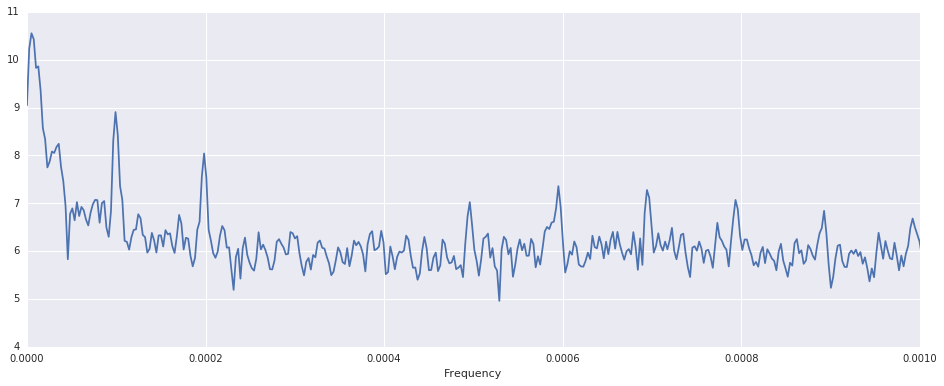

In [15]:
from scipy import signal
f, Pxx_den = signal.welch(usage_count - np.mean(usage_count), fs, nperseg=5000)
plt.figure(figsize=(16,6))
plt.plot(f, np.log10(Pxx_den))
plt.xlim([0, .001])
plt.xlabel('Frequency')

We see a very strong peak near zero frequency. This is due to the long term trends that we saw in the first histogram and we can ignore this. The next strongest peak occurs somewhere around 0.0001, let's pull that out and see what period it corresponds to.

In [16]:
psd = Series(Pxx_den)
f_low_peak = f[psd[f > 0.00007].idxmax()]
1/f_low_peak

10079.974358974358

This gives us a period of 10079.97 units. This is conveniently close to the number of minutes in a week which is 10080. We can conclude that time is given in units of minutes.

We can now make new cyclic time features that are the hour of the day and day of week. We will also normalize these feature while we're at it.

In [17]:
df['dayofweek'] = (df['time'] // (60*24)) % 7 / 7 - 0.5
df['hour'] = (df['time'] // 60) % 24 / 24 - 0.5

We can check that our data looks cyclic with these day and week lengths.

(4000000.0, 4400000.0)

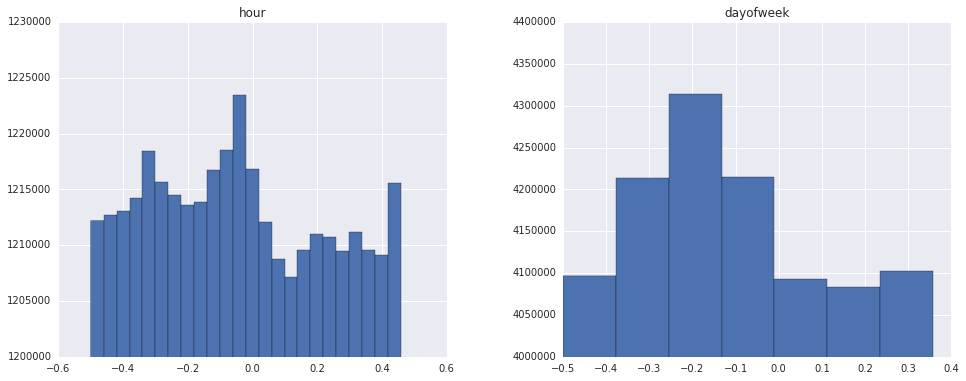

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for cycle, ax, bins in zip(['hour', 'dayofweek'], axs, [24, 7]):
    df.hist(column=cycle, figsize=(18,6), ax=ax, bins=bins)
axs[0].set_ylim([1.2E6,1.23E6]); axs[1].set_ylim([4E6, 4.4E6])

Let's look at the time distribution for some of our top places to see how unique these locations are. We see all sort of interesting trends here. Our second location seems to be only open on weekends and during a different half of the hours in a day, maybe this corresponds to a nightclub or some other nocturnal establishment.

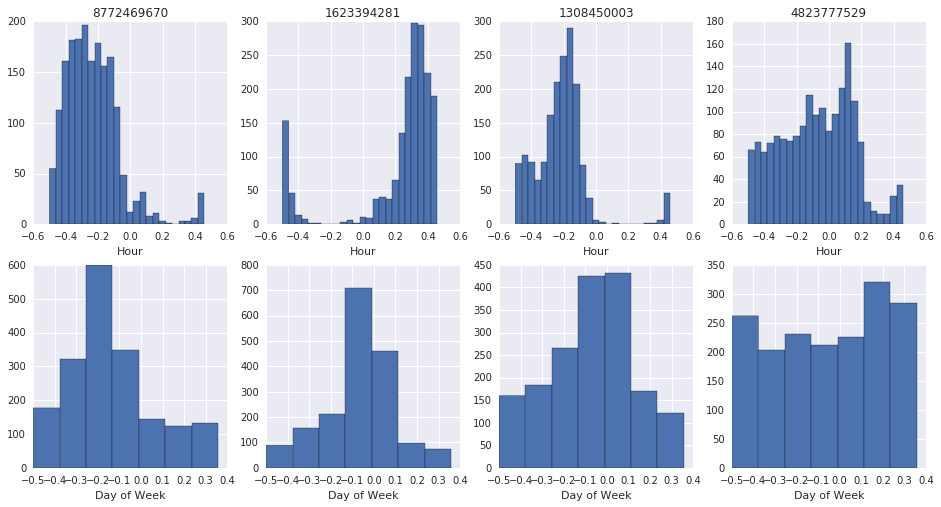

In [19]:
fig, axs  = plt.subplots(2, 4, figsize=(16, 8))
for i, (ax_day, ax_week) in enumerate(zip(axs[0], axs[1])):
    place = highest_place_ids[i]
    df[df['place_id'] == place]['hour'].hist(bins=24, ax=ax_day)
    ax_day.set_title(place)
    ax_day.set_xlabel('Hour')
    df[df['place_id'] == place]['dayofweek'].hist(bins=7, ax=ax_week)
    ax_week.set_xlabel('Day of Week')

# Long term trends
Switching gears from cyclic features, we can check for long term trends. First we see that the test data set occurs sequentially after the training dataset in time.

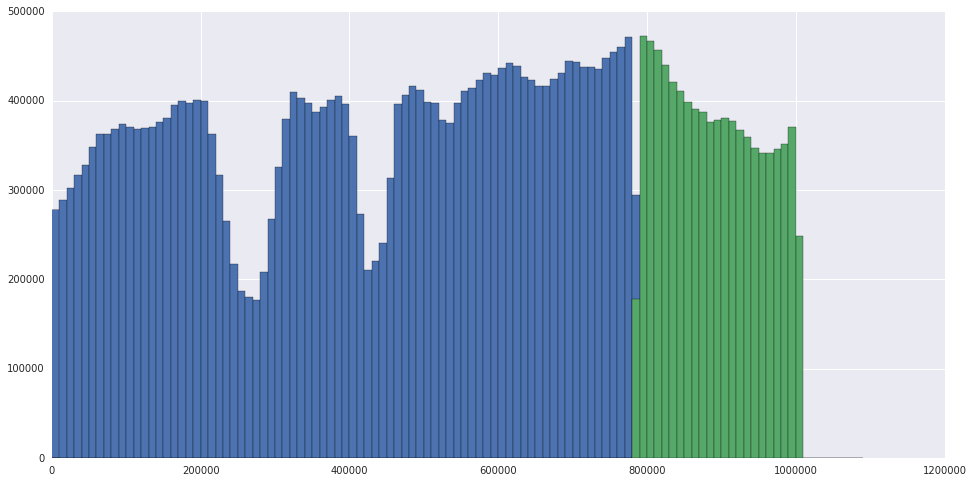

In [20]:
fig, ax  = plt.subplots(1, 1, figsize=(16, 8))
df['time'].hist(bins=range(0, 1100000, 10000), ax=ax)
final['time'].hist(bins=range(0, 1100000, 10000), ax=ax)

We can then look at the popularity of some of our most populary locations over time. We see some very strong trends happening here with two locations even dieing out towards the end of the dataset. The simplest way we can account for these trends is to only use data to train our model that is close to the points in time that we can to predict a check in. Since our test set occurs after our training set in time, we will experiment with dropping out the beginning portions of our training set all together so that we only keep data that is of approximately the same portion in these long term trends. 

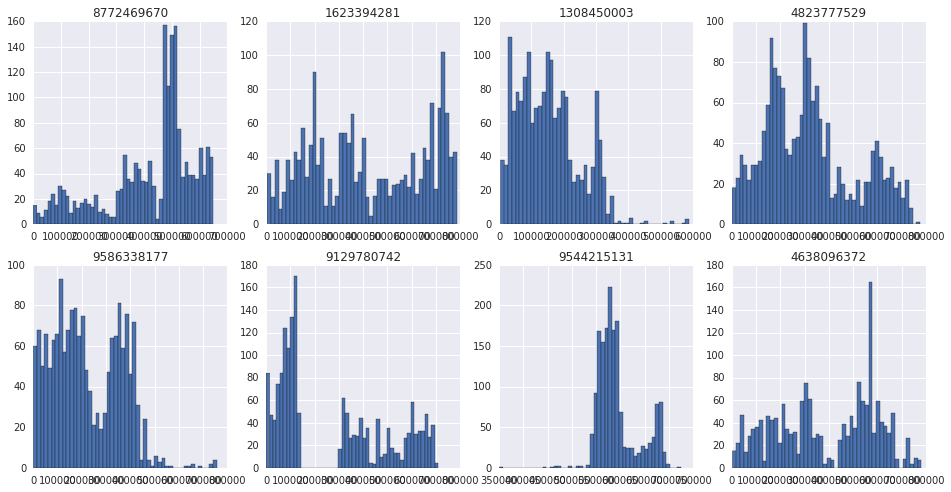

In [21]:
fig, axs  = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axs.ravel()):
    place = highest_place_ids[i]
    df[df['place_id'] == place]['time'].hist(bins=50, ax=ax)
    ax.set_title(place)

# Standardizing the data
We will be using variations of knn so it is very important that we normalize our dataset. We already scaled our day and week measures earlier. To scale x and y coordinates, we will calculate the weighted average of the standard deviation for each place group. We will then transform each axis by this average. This is particularily important since we know that the location data has much greater variance along the x coordinate.

In [22]:
x_std_mean = place_grouped['x'].std().mean()
y_std_mean = place_grouped['y'].std().mean()
print(x_std_mean, y_std_mean)

df['x']  = df['x'] / x_std_mean
df['y']  = df['y'] / y_std_mean

0.680755561936 0.0208191008939


We will also drop the *accuracy* parameter from the dataset for now to speed up computations. We will keep the *time* column so that we can adjust the training/test sets but need to make sure to not use it in our model as we should only use our cyclic time parameters.

In [25]:
df.drop('accuracy', axis=1, inplace=True)

# Training Grid KNN

We have a problem of a large dataset with a very large number of labels. KNN works great for handling the large number of labels but scales terribly with big datasets. To combat this we will split our parameter space into grids and perform KNN on these smaller grids. This is essentially pruning the data before sending it into the KNN model and is assuming that points in far away grid cell are very unlikely to be near neighbors.

We will split our data using only the *x* and *y* coordinates as these are the two parameters we are most confident that our assumption holds with. To bin these parameters we can simply take the values and round them to the closest integer.

In [26]:
df['x_grid'] = df['x'].astype(int)
df['y_grid'] = df['y'].astype(int)

In [27]:
df.head()

,x,y,time,place_id,dayofweek,hour,x_grid,y_grid
row_id,,,,,,,,
0,1.166498,436.181180,470702,8523065625,0.071429,0.375000,1,436
1,8.750130,230.403802,186555,1757726713,-0.071429,0.041667,8,230
2,12.203793,338.184633,322648,1137537235,-0.500000,-0.458333,12,338
3,10.821065,120.874576,704587,6567393236,0.357143,-0.208333,10,120
4,6.016991,54.310703,472130,7440663949,0.214286,0.333333,6,54


We can pull out the limits of our grid.

In [28]:
grid_limits = DataFrame({'Min': df[['x_grid', 'y_grid']].min(), 'Max': df[['x_grid', 'y_grid']].max()})
grid_limits

,Max,Min
x_grid,14,0
y_grid,480,0


We can now build a knn model centered at each cell in this grid. The knn training set for each of these models will then include the center cell but also a certain number of the surrounding cells on each side. This will ensure that that sufficient data is provided and that the grid lines would cause any strange border affects. Since we already normalized the *x* and *y* coordinates into units of place_id standard deviation, taking 3 cells in all directions of the center cell should be sufficient.

This problem is also perfectly setup for multithreading so we will use the *multiprocessing* library to make use of all of our cores.

Accuracy in this competition is also calculated by allowing up to 3 predictions for each sample, so we will find the 3 most likely place_ids for each point.

# Test/train split
To measure the effectiveness of our model, we will split the given training set into a test and new training set. Normally, this might be done by randomly sampling, but since we see that our final dataset occurs sequentially later in time, we will mimic this by having our test set occur after our new training set.

Since we also saw some long term trends, where we cutoff the beginning of our training set is a parameter we may wish to tune. Cutting off too much could be excluding good data, while cutting off too little could lead to long term trends confusing our model.

In [29]:
train_mask = (df['time'] > 700000) & (df['time'] < 780000)
test_mask = (df['time'] >= 780000) & (df['time'] < 781000)

test = df[test_mask]
train = df[train_mask]

In [30]:
print('Test size: ', len(test))
print('Train size: ', len(train))

Test size:  48113
Train size:  3585942


In [31]:
test.head()

,x,y,time,place_id,dayofweek,hour,x_grid,y_grid
row_id,,,,,,,,
559,1.421949,105.201469,780559,6262911124,-0.071429,-0.458333,1,105
837,6.253199,322.573969,780543,2928523788,-0.071429,-0.458333,6,322
1106,7.571881,413.197479,780563,3610102623,-0.071429,-0.458333,7,413
1982,0.417624,117.718820,780018,2067031359,-0.214286,0.166667,0,117
2351,13.773666,10.043661,780390,9351738333,-0.214286,0.416667,13,10


# Model

In [32]:
from joblib import Parallel, delayed
import multiprocessing
from sklearn.neighbors import KNeighborsClassifier

import time

In [33]:
def knnWithinGrid(xg, yg):
    # Grid width equals 2*n+1
    n = 3

    # Subsetting points to use for knn training set
    search_grid = train[(train['x_grid']<=(xg+n)) & (train['x_grid']>=(xg-n)) &
                     (train['y_grid']<=(yg+n)) & (train['y_grid']>=(yg-n))]

    # Subsetting points to evaluate
    test_samples = test[(test['x_grid']==xg) & (test['y_grid']==yg)]

    # Checking if there are samples to classify, if not returning appropriate empty arrays
    if len(test_samples) == 0:
        return np.array([], dtype='int64'), np.ndarray(shape=[0,3], dtype='int64')

    # Performing knn on test_samples using search_grid as training data
    knn = KNeighborsClassifier(n_neighbors=5).fit(search_grid[['x', 'y', 'dayofweek', 'hour']], 
                                                  search_grid['place_id'])

    # Evaluating top 3 predictions for each test sample
    pred_ind = knn.predict_proba(test_samples[['x', 'y', 'dayofweek', 'hour']]).argsort(axis=1)
    pred_ind = np.fliplr(pred_ind)
    top3_pred = knn.classes_[pred_ind[:, 0:3]]
    return test_samples.index.values, top3_pred

num_cores = multiprocessing.cpu_count()
start = time.time()
predictions = Parallel(n_jobs=num_cores)(delayed(knnWithinGrid)(xg,yg) 
                                         for xg in range(grid_limits.ix['x_grid', 'Min'], 
                                                         grid_limits.ix['x_grid', 'Max']+1) 
                                         for yg in range(grid_limits.ix['y_grid', 'Min'], 
                                                         grid_limits.ix['y_grid', 'Max']+1))
end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  100.81415271759033


We can now combine each of our grid cell results back into a single dataframe.

In [34]:
row_id, place_id = zip(*predictions)
p_df = DataFrame(np.concatenate(place_id), 
                         index=np.concatenate(row_id), columns=['Pred1', 'Pred2', 'Pred3'])

In [35]:
p_df.head()

,Pred1,Pred2,Pred3
7232491,9510636433,9516247724,8813608705
8026079,4941765890,8244276451,9510636433
12936343,8370753254,9973067176,4120068991
26927041,6323629255,7540493790,4941765890
6502422,4941765890,2046572374,3760678683


Let's now create an accuracy dataframe containing the predictions and true label for each point in the test set.

In [36]:
acc_df = pd.concat([test['place_id'], p_df], axis=1)
acc_df.head()

,place_id,Pred1,Pred2,Pred3
559,6262911124,6262911124,6064010375,2463210131
837,2928523788,5845095861,2928523788,7796057365
1106,3610102623,3610102623,4995292420,8041436527
1982,2067031359,2067031359,9998323806,3252321210
2351,9351738333,4407144557,6941813681,7539221419


In [37]:
top3_acc = (sum(acc_df['place_id'] == acc_df['Pred1']) + 
            sum(acc_df['place_id'] == acc_df['Pred2']) + 
            sum(acc_df['place_id'] == acc_df['Pred3'])) / len(acc_df)
print('Top 3 accuracy: ', top3_acc)

Top 3 accuracy:  0.508989254463


# Next Steps
- Quick testing of nearest neighbor number and training grid size shows little effect on accuracy, confirm this formally by varying these numbers and plotting the change in accuracy.
- Assumed that only using a subset of observations closest to the test set would increase accuracy as these points would be approximately equal in time on the scale of the long term trends. This was observed because some locations have very different responses over the long term. Some trends might be yearly (which we would want to include), but others looked like the locations had either shut down or only opened half way through the data set (which we would want to eliminate). Should vary the starting cutoff of the training set and see it's affect on accuracy.
- Test/train split needs to be done sequentially in time with the training set sitting before the test set. For simplicity only a single split was used in this model but a more accurate approach would be to use a range of test/train sets across the data set in time. These could be produced using a rolling window. To handle the computation needed for this, it might be worth implementing saving intermediate results to disc. Since the GCE instance used is non-persistent (for cost savings), there is a chance that the instance can shutdown.
